#### Imports and env creation

In [14]:
# from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX
import pygame

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
WORLD_N=7
WORLD_N_SQ = WORLD_N**2

class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=WORLD_N,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"
    # MiniGridEnv._gen_grid
    
    def _gen_grid(self, width, height):
      self.grid = Grid(width, height)
      self.grid.wall_rect(0, 0, width, height)

      if self.agent_start_pos is not None:
          self.agent_pos = self.agent_start_pos
          self.agent_dir = self.agent_start_dir
      else:
          self.place_agent()
      self.valid_actions = {Actions.left, Actions.right, Actions.forward}
    
      
      self.put_obj(Goal(), width - 2, height - 2)
      
      self.grid.set(3, 1, Wall())
      self.grid.set(3, 2, Wall())
      self.grid.set(3, 4, Wall())
      self.grid.set(3, 5, Wall())
    #   for i in range(0, height):
    #     self.grid.set(5, i, Wall())

    #   self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
    #   self.grid.set(3, 6, Key(COLOR_NAMES[0]))
    
    def get_array_repr(self, with_agent=True):
        grid_array = self.unwrapped.grid.encode()[:,:,0]
        # print(grid_array)
        # print(self.agent_pos)
        grid_array[self.agent_pos[0],self.agent_pos[1]]=OBJECT_TO_IDX['agent']
        return grid_array.T
    

# env = SimpleEnv(render_mode="human")
# manual_control = ManualControl(env, seed=42)

env = SimpleEnv()
env.reset()
print(env.get_array_repr())
print(env.gen_obs())
env.get_pov_render(200)
# enable manual control for testing
# manual_control.start()

# numbers = [0,1,2,3,4,5,6,7,8,9,10]
# colors = [0,1,2,3,4,5,6]

[[ 2  2  2  2  2  2  2]
 [ 2 10  1  2  1  1  2]
 [ 2  1  1  2  1  1  2]
 [ 2  1  1  1  1  1  2]
 [ 2  1  1  2  1  1  2]
 [ 2  1  1  2  1  8  2]
 [ 2  2  2  2  2  2  2]]
{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[0, 0, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[0, 0, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[0, 0, 0],
        [2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[0,

#### Agent motion

In [37]:
from agents.random import RandomAgent
n_steps_train = 8000
n_steps_test = 2000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list_train = []

def rgb_to_continuous(value, direct, new_arr):
    val = value[0]
    if (value[0]==10):
        val+=direct
    val *= 10
    val += value[1]
    return torch.tensor([val])

for i in range(n_steps_train):
    action = random_action_agent.act()
    arr = env.gen_obs()['image']
    new_arr = []
    for j in arr:
        for k in j:
            new_arr.append(rgb_to_continuous(k,env.agent_dir,new_arr))
    new_arr = np.append(new_arr, [actions_to_idx[action], env.agent_dir])
    image_list_train.append(new_arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)
    # print(env.get_array_repr())

env.reset()
image_list_test = []

for i in range(n_steps_test):
    action = random_action_agent.act()
    arr = env.gen_obs()['image']
    new_arr = []
    for j in arr:
        for k in j:
            new_arr.append(rgb_to_continuous(k,env.agent_dir,new_arr))
    new_arr = np.append(new_arr, [actions_to_idx[action], env.agent_dir])
    image_list_test.append(new_arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)

print(image_list_train[:3])

[array([ 0,  0, 25, 10, 10, 25, 10,  0,  0, 25, 10, 10, 25, 10,  0,  0, 25,
       10, 10, 10, 10,  0,  0, 25, 10, 10, 25, 10,  0,  0, 25, 81, 10, 25,
       10,  0,  0, 25, 25, 25, 25, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 25, 25, 25, 25,  0,  0, 25,
       10, 10, 10, 10,  0,  0, 25, 10, 10, 10, 10,  0,  0, 25, 25, 25, 10,
       25,  0,  0, 25, 10, 10, 10,  0,  0,  0, 25, 10, 10, 10,  0,  1,  3]), array([ 0,  0, 25, 10, 10, 25, 10,  0,  0, 25, 10, 10, 25, 10,  0,  0, 25,
       10, 10, 10, 10,  0,  0, 25, 10, 10, 25, 10,  0,  0, 25, 81, 10, 25,
       10,  0,  0, 25, 25, 25, 25, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0])]


In [34]:
print(image_list_train[:3])
print(image_list_test[:3])

[array([ 0,  0, 25, 10, 10, 10,  0,  0,  0, 25, 25, 25, 10, 25,  0,  0, 25,
       10, 10, 10, 10,  0,  0, 25, 10, 10, 10, 10,  0,  0, 25, 25, 25, 25,
       25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]), array([ 0,  0,  0, 25, 10, 10, 10,  0,  0,  0, 25, 25, 25, 10,  0,  0,  0,
       25, 10, 10, 10,  0,  0,  0, 25, 10, 10, 10,  0,  0,  0, 25, 25, 25,
       25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 25, 25,  0,  0,  0,
        0, 25, 10, 10,  0,  0,  0,  0, 25, 10, 10,  0,  0,  0,  0, 25, 25,
       25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2])]
[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 25,
       25, 25, 25, 25,  0, 25, 10, 10, 25, 10, 10,  0, 25, 10, 10, 25, 10,
       10,  0, 25, 10, 10, 10, 10, 10,  0, 25, 10, 10, 25, 10, 10,  0]), array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 25, 25,  0,  0, 

#### Helper functions

In [17]:
import torch
from torch import nn, optim

In [19]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cpu


In [60]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='mse',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device('cpu')
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device)
  target_train = target_train.to(device)
  input_test = input_test.to(device)
  target_test = target_test.to(device)

  input_train = input_train.float()
  target_train = target_train.float()
  input_test = input_test.float()
  target_test = target_test.float()


  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
    # batches = torch.split(input_train[shuffle_idx], batch_size)
    # for batch in batches:
    #   output_train = net(batch)
    #   loss = loss_fn(output_train, batch)
    for batch_input, batch_target in batches:
      batch_input = batch_input.float()
      batch_target = batch_target.float()
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()
  print(device)


#### Input preparation

In [57]:
# test_size=0.2
# cutoff = int((1-test_size)*len(image_list))
X_train, X_test = image_list_train, image_list_test 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)


def one_hot_encode_set(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    one_hot = torch.zeros(len(classes))
    one_hot[classdict[values.item()]] = 1
    return one_hot

def continuous_class(values, classes, direct):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()]
    if (values.item()==10):
        val+=direct
    return torch.tensor([val])

def rgb_to_continuous(values, classes, direct):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()[0]]
    if (values.item()[0]==10):
        val+=direct
    val *= 10
    val += values.item()[1]
    return torch.tensor([val])

# Define a function for one-hot encoding
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array, mode):
    if mode == 'in':
    
        # first_part = torch.cat([one_hot_encode(input_array[i], 11) for i in range(25)])
        # first_part = torch.cat([one_hot_encode_set(input_array[i], map_numbers) for i in range(25)])
        # first_part = torch.cat([continuous_class(input_array[i], map_numbers, input_array[1+WORLD_N_SQ]) for i in range(WORLD_N_SQ)])

        # 26th position: one-hot encoded into 3 classes
        # second_part = one_hot_encode(input_array[WORLD_N_SQ], 3)
        
        # Last position: one-hot encoded into 4 classes
        # third_part = one_hot_encode(input_array[26], 4)

        # print(torch.cat([first_part, second_part, third_part], dim=0))
        # Concatenate all parts to form the final one-hot encoded array
        # return torch.cat([first_part, second_part], dim=0)
        # print(input_array)
        # print(input_array[:-1])
        # print(input_array[:-1].size(0))
        return input_array[:-1]
    elif mode == 'out':
        return input_array[:-2]
        # return torch.cat([continuous_class(input_array[i], map_numbers, input_array[1+WORLD_N_SQ]) for i in range(WORLD_N_SQ)])


# Apply to the whole dataset
input_orientation_train = [x[1+WORLD_N_SQ] for x in input_train]
input_orientation_test = [x[1+WORLD_N_SQ] for x in input_test]
target_orientation_train = [x[1+WORLD_N_SQ] for x in target_train]
target_orientation_test = [x[1+WORLD_N_SQ] for x in target_test]

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x, 'in') for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in') for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out') for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out') for x in target_test])


print(target_train_processed)
print(input_train_processed)


tensor([[ 0,  0,  0,  ..., 10, 10,  0],
        [ 0,  0, 25,  ...,  0,  0,  0],
        [ 0,  0,  0,  ..., 10, 10,  0],
        ...,
        [ 0,  0,  0,  ...,  0, 25, 25],
        [ 0,  0,  0,  ...,  0, 25, 25],
        [ 0,  0,  0,  ...,  0, 25, 25]])
tensor([[ 0,  0, 25,  ...,  0,  0,  0],
        [ 0,  0,  0,  ..., 10,  0,  1],
        [ 0,  0, 25,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 25, 25,  2],
        [ 0,  0,  0,  ..., 25, 25,  2],
        [ 0,  0,  0,  ..., 25, 25,  2]])


#### Autoencoder definition

In [72]:
encoding_size=100
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size * 30)),
    nn.ReLU(),
    nn.Linear(int(input_size * 30), encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, int(output_size * 30)),
    nn.ReLU(),
    nn.Linear(int(output_size *30), output_size),
    )

# model[:-2].apply(init_weights_kaiming_normal)

n_l = 4
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=50, out_features=1500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1500, out_features=100, bias=True)
  (3): ReLU()
)

Decoder 

 Sequential(
  (4): Linear(in_features=100, out_features=1470, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1470, out_features=49, bias=True)
)


#### Autoencoder training

Using device: cpu
Epoch 	 Loss train 	 Loss test
1/40	 86.0307		 85.4504
2/40	 63.9052		 63.3598
3/40	 19.6984		 22.0056
4/40	 11.7041		 13.5604
5/40	 10.0025		 11.4300
6/40	 10.4274		 12.0427
7/40	 10.0361		 11.0309
8/40	 9.3207		 10.7799
9/40	 10.2071		 11.8022
10/40	 12.2033		 14.0721
11/40	 9.2209		 11.1583
12/40	 9.2734		 10.3433
13/40	 13.6265		 14.1785
14/40	 9.2699		 10.7647
15/40	 9.2466		 10.8317
16/40	 9.5100		 11.2891
17/40	 9.5588		 10.9069
18/40	 9.3766		 11.0091
19/40	 9.1834		 10.5882
20/40	 9.0516		 10.5221
21/40	 9.1358		 11.0417
22/40	 9.2272		 11.0757
23/40	 17.3835		 17.2555
24/40	 8.9741		 11.0876
25/40	 9.1497		 10.7692
26/40	 9.0644		 10.4761
27/40	 9.2136		 10.9903
28/40	 9.3335		 10.9378
29/40	 12.4529		 14.4074
30/40	 8.9662		 10.7060
31/40	 9.0387		 10.7225
32/40	 8.8982		 10.4492
33/40	 9.1009		 10.9159
34/40	 9.1882		 10.5480
35/40	 9.5350		 11.4569
36/40	 9.0085		 10.7304
37/40	 9.0053		 10.5966
38/40	 9.0364		 10.6058
39/40	 9.0553		 10.3470
40/40	 10.45

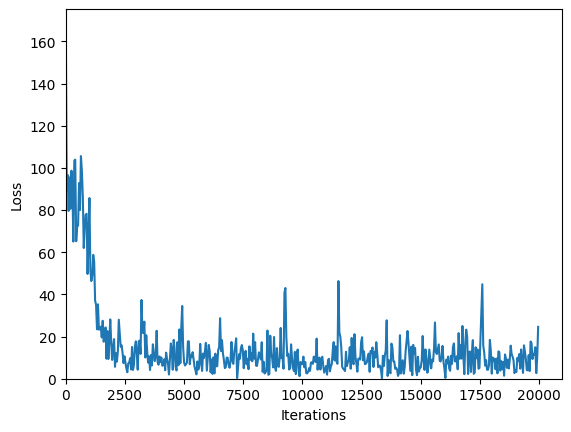

cpu


In [73]:
n_epochs = 40
batch_size = 16

runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [78]:
input_test_processed = input_test_processed.float().to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
# torch.set_printoptions(profile="full")
# print(output)
output = output.cpu() 
# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

# incorrect_agent_num=0
# incorrect_agent_location=0
# incorrect_orientation=0
incorrect_cell=0
incorrect_type=0
not_perfect=0

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    fist_NSQ = output[i]
    # second_block = output[i, input_train_processed.size(1)-7:input_train_processed.size(1)-4]    # Next block of size 3
    # third_block = output[i, input_train_processed.size(1)-7:]             # Last block of size 4

    # Decode each block by taking the argmax (index of max value)
    decoded_fist_NSQ = torch.round(fist_NSQ).long()  # 25 values, each between 0-10
    decoded_fist_NSQ = decoded_fist_NSQ.clamp(min=0)
    # decoded_second = torch.argmax(second_block)       # Single value between 0-2
    # decoded_third = torch.argmax(third_block)         # Single value between 0-3
    
    # map_array = [(10*i+j for fori in range(14))]
    # in_map_array = torch.isin(decoded_fist_NSQ, torch.tensor(range(len(map_array))))
    # Convert values not in map_array to len(map_array)
    # adjusted_values = torch.where(in_map_array, decoded_fist_NSQ, torch.tensor(len(map_array)))
    # mapping = torch.tensor(map_array+[-1])
    # decoded_fist_NSQ = mapping[adjusted_values]

    num_agents = 0
    maybe_perfect=1

    for j, val in enumerate(decoded_fist_NSQ):
        if (target_test[i, j] != val):
            # print("cell", i)
            maybe_perfect=0
            incorrect_cell +=1
        if (target_test[i, j]//10 != val//10):
            incorrect_type +=1
    
    # decoded_fist_NSQ[decoded_fist_NSQ > 10] = 10

    # if num_agents != 1:
    #     decoded_second = torch.tensor(-1, dtype=torch.long)
    #     maybe_perfect=0
    #     incorrect_agent_num +=1
    
    # if (decoded_second != target_orientation_test[i]):
    #     maybe_perfect=0
    #     incorrect_orientation +=1

    if not maybe_perfect:
        not_perfect +=1

    # Use torch.masked_select to get all matching values
    # matches = torch.masked_select(decoded_fist_NSQ, decoded_fist_NSQ >= 10)

    # Ensure it's a 1D tensor for concatenation
    # decoded_second = decoded_second.unsqueeze(0)

    # Combine the decoded values into a single list for this observation
    # decoded_sample = torch.cat([decoded_fist_NSQ, decoded_second])
    
    # Append the decoded sample to the final list
    decoded_outputs.append(decoded_fist_NSQ)

acc_cell = 1.0-(incorrect_cell/(WORLD_N_SQ*output.size(0)))
acc_type = 1.0-(incorrect_type/(WORLD_N_SQ*output.size(0)))
# acc_orientation = 1.0-(incorrect_orientation/output.size(0))
# acc_agentloc = 1.0-(incorrect_agent_location/output.size(0))
# acc_agentnum = 1.0-(incorrect_agent_num/output.size(0))
acc_perfect = 1.0-(not_perfect/output.size(0))

# Convert to tensor if needed
# decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

print ("Cell accuracy:", acc_cell)
print ("Type accuracy:", acc_type)
# print ("Agent orientation accuracy:", acc_orientation)
# print ("Number of agents accuracy:", acc_agentnum)
# print ("Agent location accuracy:", acc_agentloc)
print ("Perfectness:", acc_perfect)

[tensor([ 0, 25,  9, 10, 10,  0,  0,  0, 25, 25, 25,  9, 26, 25,  0, 25,  9, 10,
        11, 10, 10,  0, 25, 12, 10, 11, 11, 10,  0, 25, 25, 25, 26, 26, 24,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0, 25, 10,  0,  0,  0,  0,  0, 26, 11,  0,  0,  0,  0,
         0, 26, 10,  0,  0,  0,  0,  0, 25, 10,  0,  0,  0,  0,  0, 26, 27,  0,
         0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0]), tensor([ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1, 24, 24,  0,  0,  0,  0,  1, 24, 10,  0,  0,  0,  0,  1, 24, 10,  0,
         0,  0,  0,  1, 24, 24,  0,  0,  0,  1,  0,  0,  0]), tensor([ 0,  0, 15,  6,  6, 25, 10,  0,  0, 15,  7,  6, 17, 10,  0,  0, 15,  6,
         6, 25, 11,  0,  0, 15, 23,  6, 25, 10,  0,  0, 15, 15, 15, 26, 25,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0]), tensor([ 0, 25,  9, 10, 10,  0,  1,  0, 25, 24, 25, 11, 26, 25,  0, 25, 10, 11,
        10, 10, 10,  0, 25, 11,

In [79]:
interval_min=1300
interval_size=30
for i in range(interval_min,interval_min+min(interval_size,len(decoded_outputs))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    print("Input Grid:")
    print(input_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Decoded grid (first 25 values reshaped into 5x5)
    print("Decoded Grid:")
    print(decoded_outputs[i][:WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Target test grid (first 25 values reshaped into 5x5)
    print("Target Grid:")
    print(target_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Action and Orientation for input, decoded, and target test
    print(f"Input Action: {input_test[i, WORLD_N_SQ].item()}")
    print(f"Target Orientation: {target_orientation_test[i].item()} | Input Orientation: {input_orientation_test[i].item()}")
    
    print("=" * 50)  # Separator


Sample 1301:
Input Grid:
tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 25, 25],
        [ 0,  0,  0,  0,  0, 25, 10],
        [ 0,  0,  0,  0,  0, 25, 10],
        [ 0,  0,  0,  0,  0, 25, 10],
        [ 0,  0,  0,  0,  0, 25, 10]], dtype=torch.int32)
Decoded Grid:
tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 26, 26],
        [ 0,  0,  0,  0,  0, 26, 12],
        [ 0,  0,  0,  0,  0, 26, 10],
        [ 0,  0,  0,  0,  0, 26, 26],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0,  0]], dtype=torch.int32)
Target Grid:
tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 25, 25],
        [ 0,  0,  0,  0,  0, 25, 10],
        [ 0,  0,  0,  0,  0, 25, 10],
        [ 0,  0,  0,  0,  0, 25, 25],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)
Input Action: 0
Target Orientation: 3 | Input Orientation: 0
Sample 1302:
Input Grid:
tens

In [80]:
#Colorless analysis

interval_min=1300
interval_size=30



for i in range(interval_min,interval_min+min(interval_size,len(decoded_outputs))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    print("Input Grid:")
    print(input_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int()//10)
    
    # Decoded grid (first 25 values reshaped into 5x5)
    print("Decoded Grid:")
    print(decoded_outputs[i][:WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int()//10)
    
    # Target test grid (first 25 values reshaped into 5x5)
    print("Target Grid:")
    print(target_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int()//10)
    
    # Action and Orientation for input, decoded, and target test
    print(f"Input Action: {input_test[i, WORLD_N_SQ].item()}")
    print(f"Target Orientation: {target_orientation_test[i].item()} | Input Orientation: {input_orientation_test[i].item()}")
    
    print("=" * 50)  # Separator


Sample 1301:
Input Grid:
tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1]], dtype=torch.int32)
Decoded Grid:
tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
Target Grid:
tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
Input Action: 0
Target Orientation: 3 | Input Orientation: 0
Sample 1302:
Input Grid:
tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 2],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 0, 2, 